In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix
from fpdf import FPDF

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

In [2]:
# Verificar si TensorFlow detecta GPU
import tensorflow as tf
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Configurar para usar la GPU si está disponible
if tf.config.experimental.list_physical_devices('GPU'):
    # Limitar la cantidad de VRAM a utilizar si es necesario
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


In [41]:
# Cargar el dataset desde el archivo .pickle
archivo_pickle = 'affective_dataset_v2.pkl'
with open(archivo_pickle, 'rb') as f:
    df_imagenes = pickle.load(f)


In [42]:
import pandas as pd
pd_pandas = pd.read_pickle('affective_dataset_v2.pkl')
pd_pandas.head()

,image,face_closeup,face_landmarks,label
0,"[[165, 166, 164, 167, 167, 166, 167, 167, 167,...","[[161, 160, 161, 161, 161, 161, 161, 160, 99, ...","[[62, 83], [62, 88], [63, 93], [63, 97], [64, ...",bored
1,"[[165, 166, 165, 166, 167, 167, 167, 167, 167,...","[[160, 161, 160, 161, 161, 162, 161, 162, 132,...","[[62, 83], [62, 88], [63, 93], [63, 97], [64, ...",bored
2,"[[165, 165, 165, 166, 167, 166, 166, 167, 167,...","[[160, 161, 161, 60, 36, 76, 88, 88, 92, 102, ...","[[63, 82], [63, 87], [63, 91], [63, 96], [65, ...",bored
3,"[[165, 166, 165, 165, 166, 167, 167, 167, 167,...","[[160, 161, 160, 45, 42, 81, 88, 88, 92, 101, ...","[[63, 83], [63, 87], [63, 92], [64, 97], [65, ...",bored
4,"[[165, 166, 166, 166, 166, 167, 166, 166, 167,...","[[160, 160, 160, 41, 43, 81, 88, 88, 92, 102, ...","[[63, 83], [63, 88], [63, 92], [64, 97], [65, ...",bored


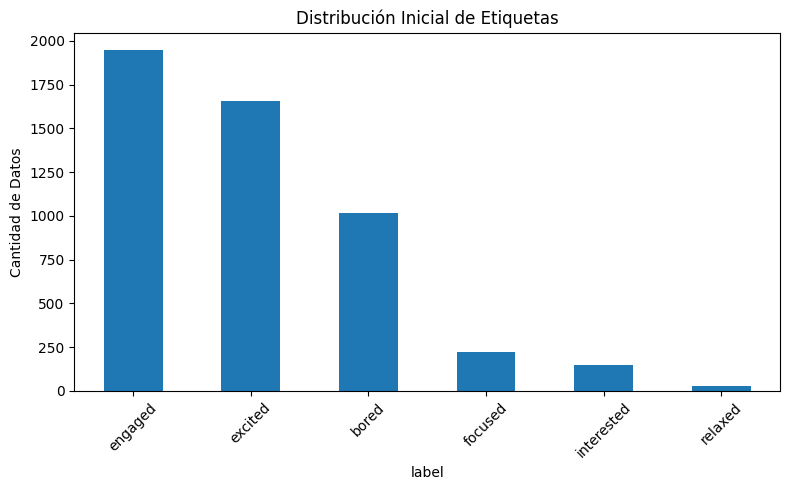

In [43]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df_imagenes['label'].value_counts().plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# No tomar en cuenta los datos desbalanceados Focused, Interested y relaxed
df_imagenes = df_imagenes[df_imagenes['label'] != 'focused']
df_imagenes = df_imagenes[df_imagenes['label'] != 'interested']
df_imagenes = df_imagenes[df_imagenes['label'] != 'relaxed']

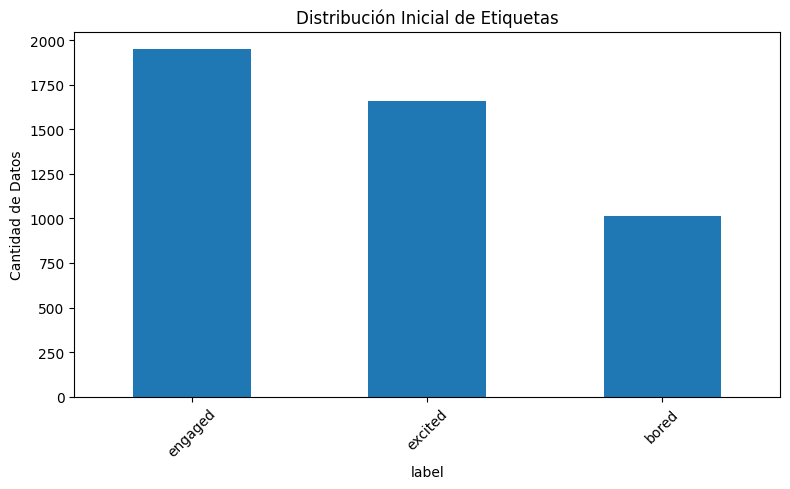

In [45]:
plt.figure(figsize=(8, 5))
df_imagenes['label'].value_counts().plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# Separar las características y etiquetas
X = np.array(df_imagenes['image'])
y = df_imagenes['label']


In [47]:
# Codificar las etiquetas
labels = y.unique()
y_encoded = pd.Categorical(y, categories=labels).codes

In [51]:
print(X[0].shape)
y_encoded[0].shape

(150, 150)


()

In [11]:
# Dividir el dataset en conjuntos de entrenamiento y validación
#X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2,stratify=y_encoded, random_state=42)


In [59]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [52]:
X = X / 255.0

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [13]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [39]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [54]:
print(X_train[0].shape)
print(y_train [0].shape)

(150, 150)
()


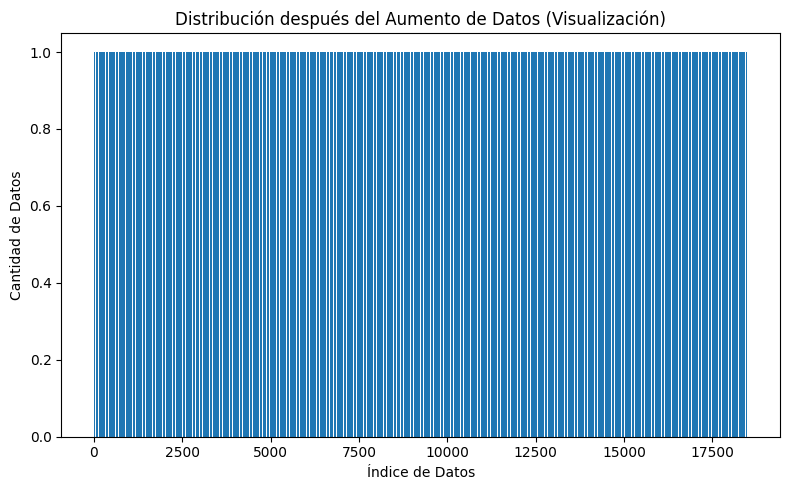

In [25]:
# Visualizar la distribución después del aumento de datos
num_aumento = 5  # Número de veces que se aplica el aumento de datos para la visualización
plt.figure(figsize=(8, 5))
plt.bar(range(len(X_train) * num_aumento), [1] * (len(X_train) * num_aumento), align='center')
plt.xlabel('Índice de Datos')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después del Aumento de Datos (Visualización)')
plt.tight_layout()
plt.show()


In [60]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150,3 )),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax')  # Capa de salida con activación softmax
])


In [61]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90:
            print('\nSe alcanzó una precisión de 90% en el entrenamiento. Se cancela el entrenamiento.')
            self.model.stop_training = True

back = myCallback()

In [62]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define el early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [63]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/100


ValueError: in user code:

    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_7" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d_21" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 150, 150)
    
    Call arguments received by layer "sequential_7" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 150, 150), dtype=float32)
      • training=True
      • mask=None


In [29]:
# Guardar el modelo
model.save('affective_CNN_trainned_stratified_672acc.h5')

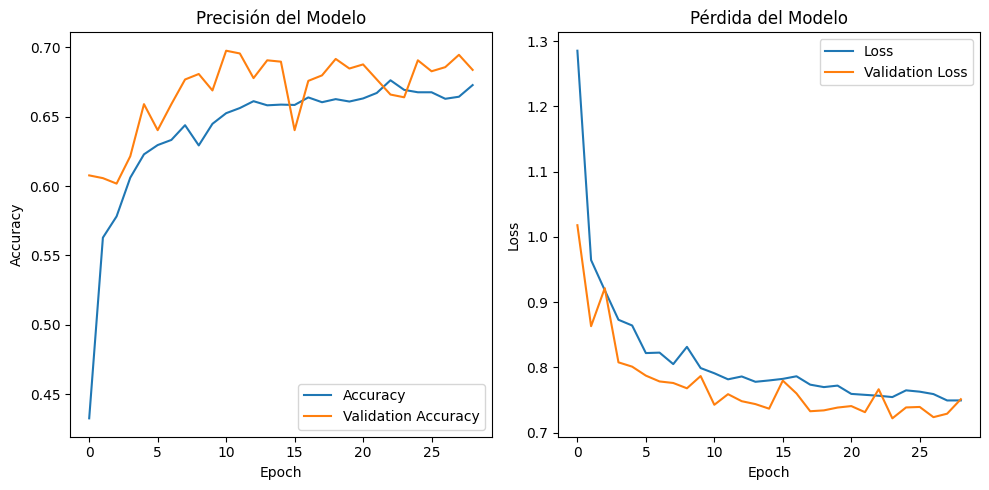

In [22]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

In [23]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 [==============================] - 1s 23ms/step


In [24]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)


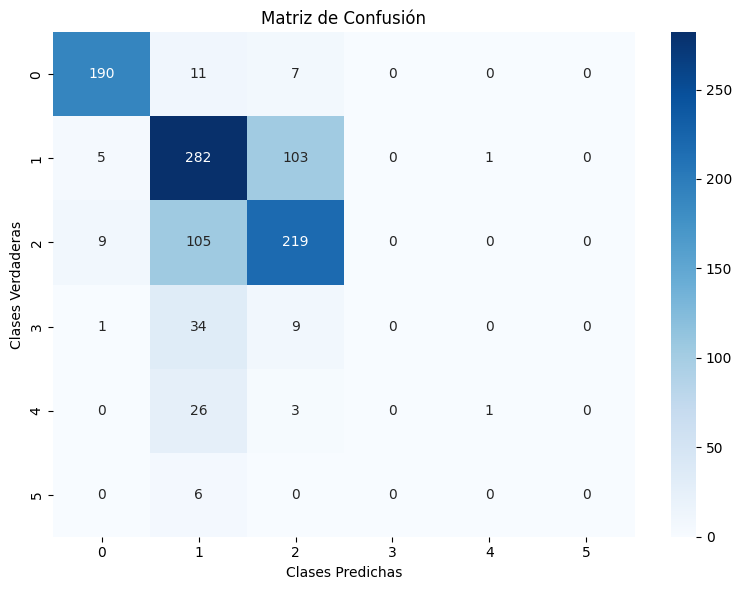

In [25]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [26]:
# Obtener las activaciones de las capas intermedias del modelo para una imagen de entrada
layer_outputs = [layer.output for layer in model.layers[1:]]  # Excluir la capa de entrada
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [27]:
# Obtener las activaciones para una imagen de entrada específica
sample_image = X_val[0].reshape(1, 150, 150, 3)  # Tomar la primera imagen del conjunto de validación como ejemplo
activations = activation_model.predict(sample_image)


1/1 [==============================] - 0s 284ms/step


ValueError: num must be an integer with 1 <= num <= 36, not 37

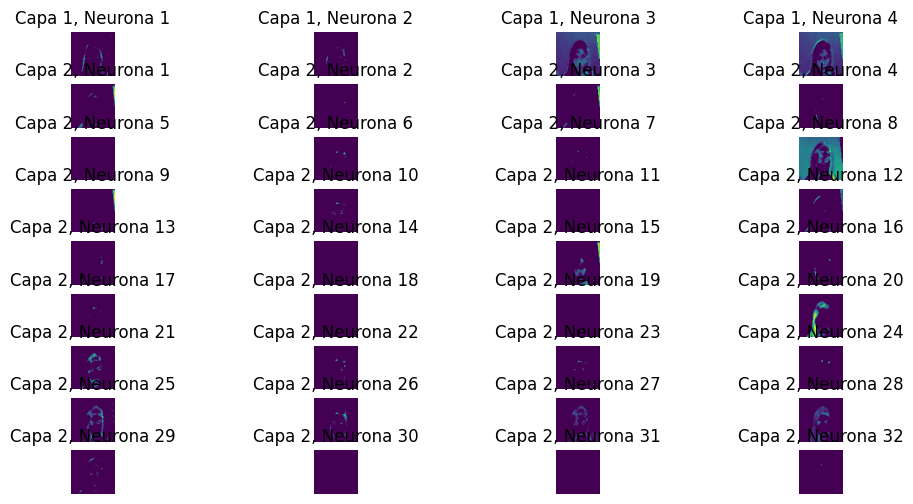

In [28]:
# Visualizar las activaciones como mapas de calor
plt.figure(figsize=(12, 6))
for i, activation_map in enumerate(activations):
    if len(activation_map.shape) == 4:  # Asegurarse de que sea un tensor 4D (por ejemplo, las activaciones de una capa Conv2D)
        for j in range(activation_map.shape[3]):
            plt.subplot(len(activations), 4, i * 4 + j + 1)
            plt.imshow(activation_map[0, :, :, j], cmap='viridis')
            plt.axis('off')
            plt.title(f'Capa {i+1}, Neurona {j+1}')
plt.tight_layout()
plt.show()